In [1]:
!pip install wandb --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.9 MB/s 
     |████████████████████████████████| 182 kB 34.9 MB/s 
     |████████████████████████████████| 162 kB 34.7 MB/s 
     |████████████████████████████████| 63 kB 615 kB/s 
     |████████████████████████████████| 162 kB 36.2 MB/s 
     |████████████████████████████████| 158 kB 39.0 MB/s 
     |████████████████████████████████| 157 kB 38.7 MB/s 
     |████████████████████████████████| 157 kB 38.6 MB/s 
     |████████████████████████████████| 157 kB 32.3 MB/s 
     |████████████████████████████████| 157 kB 37.2 MB/s 
     |████████████████████████████████| 157 kB 37.9 MB/s 
     |████████████████████████████████| 157 kB 43.1 MB/s 
     |████████████████████████████████| 157 kB 36.1 MB/s 
     |████████████████████████████████| 156 kB 36.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=bf

In [2]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

In [4]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "second_image_classifier",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model:latest",
  "deploy": "inference_result"
}

In [6]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="gildson",project=args["project_name"], job_type="Test")

logger.info("Downloading the test data")
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

wandb: Currently logged in as: gildson. Use `wandb login --relogin` to force relogin


16-10-2022 21:42:30 Downloading the test data


In [7]:
logger.info("Downloading the encoder and inference model")
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()

# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = joblib.load(model_path)

16-10-2022 21:42:34 Downloading the encoder and inference model


In [8]:
# encode the labels as integers
test_y = encoder.transform(test_y)

# train a k-NN classifier on the raw pixel intensities
logger.info("[INFO] evaluating MLP classifier...")
predict = model.predict(test_x)

16-10-2022 21:42:37 [INFO] evaluating MLP classifier...


In [9]:
print(classification_report(test_y, predict,target_names=encoder.classes_))

              precision    recall  f1-score   support

        cats       0.00      0.00      0.00       250
        dogs       0.00      0.00      0.00       250
       panda       0.33      1.00      0.50       250

    accuracy                           0.33       750
   macro avg       0.11      0.33      0.17       750
weighted avg       0.11      0.33      0.17       750



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y, predict, beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y, predict, zero_division=1,average='weighted')
recall = recall_score(test_y, predict, zero_division=1,average='weighted')
acc = accuracy_score(test_y, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

16-10-2022 21:42:49 Test Evaluation metrics
16-10-2022 21:42:49 Test Accuracy: 0.3333333333333333
16-10-2022 21:42:49 Test Precision: 0.7777777777777778
16-10-2022 21:42:49 Test Recall: 0.3333333333333333
16-10-2022 21:42:49 Test F1: 0.16666666666666666


In [11]:
encoder.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

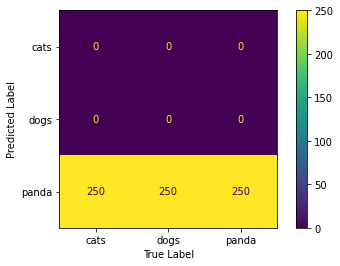

In [12]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,test_y),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [13]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

16-10-2022 21:43:09 Uploading figures


In [14]:
# create a folder named 'test'
dirname = 'test'
os.mkdir(dirname)

# re-generate test images and put all of them in test/ folder
for i in range(test_x.shape[0]):
  img = test_x[i].reshape(32,32,3)
  cv2.imwrite(os.path.join(dirname,''.join([str(i),'.jpg'])),img)

In [15]:
# sort image Paths by name
# 0.jpg, 1.jpg, 2.jpg, ....
imagePaths = list(paths.list_images("test"))
imagePaths = sorted(imagePaths, key=lambda x: int(re.search(r"(\d+)\.[a-z]+$", x).group(1)))

In [16]:
# create a table with columns we want to track/compare
preview_dt = wandb.Table(columns=["test id","image", "target","predict"])

# create a new artifact to store the EDA data
inference_result = wandb.Artifact(args["deploy"], type="INFERENCE")

In [17]:
# append all images to the artifact
for i,img in enumerate(imagePaths):
  image = cv2.imread(img)
  preview_dt.add_data(i, 
                      wandb.Image(img), 
                      encoder.inverse_transform([test_y[i]])[0], 
                      encoder.inverse_transform([predict[i]])[0])

In [18]:
# save artifact to W&B
inference_result.add(preview_dt, "Inference_Table")
run.log_artifact(inference_result)

In [19]:
run.finish()

Acc,0.33333
F1,0.16667
Precision,0.77778
Recall,0.33333
